### 0. Config and utils.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
# Mounting the drive, initializing path to data.
from google.colab import drive
drive.mount('/content/drive')
PATH = "YOUR_PATH"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device: {}".format(device))

df = pd.read_csv(PATH + "ALL_DATA.csv", index_col=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
device: cuda


In [ ]:
# CONFIG. (shares some redundant params with the other notebook)

# time series params.
prediction_size = 10  # n_t in the article
condition_size  = 100 # n_h in the article
num_series      = 2  # the dimensionality of ts.
noise_size      = 3

# discriminator params.
d_kernel_size = 3
d_stride      = 1
d_alpha       = .5
d_padding     = d_kernel_size // 2

# generator params.
g_kernel_size = 3
g_stride      = 2
g_alpha       = .5
g_padding     = g_kernel_size // 2

# transformer params.
alpha         = .9

# other params.
batch_size = 32
num_steps = 2            # the frequency of training disc per one gen training.
num_epochs = 1000
latent_space_dim = 20

In [ ]:
# Dataset.
class TSWGANDataset(torch.utils.data.Dataset):
    def __init__(self, data, prediction_size=prediction_size, condition_size=condition_size):

        # TODO: deal better with multidimensional time series 
        self.data = torch.tensor(data) 

        # if we give a 1-d array we want the dataset to set num_series=1 (first axis)
        if len(self.data.shape) == 1:
            self.data = self.data[None, :]


        self.prediction_size = prediction_size
        self.condition_size = condition_size
        self.length = self.data.shape[1] - condition_size - prediction_size + 1 # improve also 

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return (self.data[:, index:index + self.condition_size], 
               self.data[:, index+self.condition_size:index+self.condition_size+self.prediction_size])

In [ ]:
def generate_series(generator,
                    starting_points,
                    min, max, # redundant at this point
                    num_steps=num_steps,
                    num_series=num_series):
    
    generated_series = starting_points
    # history_len = starting_points.shape[-1]

    for i in range(num_steps):
        new_samples = generator(generated_series[:, :, prediction_size*i:prediction_size*i + condition_size])
        generated_series = torch.cat((generated_series, new_samples), dim=2)
    
    # decided to remove rescaling actually
    # for i in range(num_series):
    #     generated_series[0][i] = (generated_series[0][i]) * (max[i] - min[i]) + min[i]
    
    return generated_series[:, :, condition_size:]

In [ ]:
class MetaLoss:

    def __init__(self, meta_names={"None":None}, weights=None):
        self.meta_names = meta_names
        self.weights    = weights

    def apply(self,
              real_data,
              generated_data): 

        loss = .0

        w = 0
        for feature in self.meta_names.values():
            loss += self.weights[w] * feature(real_data, generated_data) 
            w += 1  
        
        return loss

In [ ]:
# Define all the meta features here. 

def k_moment(data, k=1, abs=False, center=False):
        mean = torch.mean(data) if center else 0

        if abs:
            result = torch.mean(torch.abs(data - mean)**k)
        else:
            result = torch.mean((data - mean)**k)

        return result

def exp_diff(real_data, fake_data):
    return k_moment(real_data - fake_data)

def first_k_moments_diff(real_data, fake_data, k=2, abs=False, center=False):
    loss = .0

    for i in range(1, k + 1):
        batch_size_ = real_data.size()[0]
        for b in range(batch_size_):
            loss += torch.abs(
                   k_moment(real_data[b].view(-1), k=i, abs=abs, center=center)
                 - k_moment(fake_data[b].view(-1), k=i, abs=abs, center=center)) / batch_size_

    return loss

def quantile_abs_diffs(real_data, fake_data, quantiles=[.01, .99]):
    loss = .0

    for q in quantiles:
        batch_size_ = real_data.size()[0]
        for b in range(batch_size_):
            loss += torch.abs(
                    torch.quantile(real_data[b].view(-1), torch.tensor(q), interpolation='linear', dim=0, keepdim=True)
                - torch.quantile(fake_data[b].view(-1), torch.tensor(q), interpolation='linear', dim=0, keepdim=True))[0]

    return loss

    # data shape: torch.Size([32, 2, 10])

def mean_cov_matrix(data):
    '''
    # input: data of shape: torch.Size([batch_size, num_series, prediction_size])
    returns batch-mean cov matrix
    '''
    batch_size_ = data.size()[0]
    covmat = torch.cov(data[0])


    for b in range(1, batch_size_):
        covmat += torch.cov(data[b])
    
    return covmat / batch_size_

def cov_criterion(real_data, fake_data):
    """
    Calculates the nuclear norm between cov matrices of
    real and fake series.

    TS stationarity is needed but ok.

    To change the norm change the ord argument.
    """
    loss = .0

    real_covmat =  mean_cov_matrix(real_data)
    fake_covmat =  mean_cov_matrix(fake_data)

    # Calculate the nuclear matrix norm. ABS not needed, norm is abs-scalar-linear.
    loss = torch.linalg.norm(real_covmat - fake_covmat, ord="nuc")

    return loss

def multidim_quantile_criterion(real_data, fake_data, quantiles=[.01, .99], device=device):
    
    loss = .0

    batch_size_ = real_data.size()[0]
    num_series_ = real_data.size()[1]

    for q in quantiles:
        real_q = torch.quantile(real_data, torch.tensor(q).to(device),
                                interpolation='linear',
                                dim=2, keepdim=True).view(batch_size_, num_series_)

        fake_q = torch.quantile(fake_data, torch.tensor(q).to(device),
                                interpolation='linear',
                                dim=2, keepdim=True).view(batch_size_, num_series_)

        loss += torch.linalg.norm(real_q - fake_q, ord="fro") / (batch_size_ * num_series_) 

    return loss

def pseudo_autocorrelation(data, k=prediction_size // 3):
    mean_     = torch.mean(data[:,:,k:], dim=2).view(data.size()[0], data.size()[1], -1)
    mean_lag_ = torch.mean(data[:,:,:-k], dim=2).view(data.size()[0], data.size()[1], -1)

    return torch.mean((data[:,:,k:] - mean_)*(data[:,:,:-k] - mean_lag_), dim=2)

def pseudo_autocorrelation_criterion(real_data, fake_data, k=prediction_size // 3, ord="fro"):
    batch_size_ = real_data.size()[0]
    num_series_ = real_data.size()[1]

    real_auto = pseudo_autocorrelation(real_data, k=k)
    fake_auto = pseudo_autocorrelation(fake_data, k=k)

    return torch.linalg.norm(real_auto - fake_auto, ord=ord) / (batch_size_ * num_series_)


def oscilation_regularizer(data, gamma=2):
    '''
    returns [batch_size_, num_series_] matrix with oscilation punishments
    '''
    extended_data = - torch.log(data + .02)
    return torch.mean((2 * extended_data[:,:,1:-1] - extended_data[:,:,:-2] - extended_data[:,:,2:])**2, dim=2)

def oscilation_criterion(real_data, fake_data, gamma=2, ord="fro"):
    batch_size_ = real_data.size()[0]
    num_series_ = real_data.size()[1]

    real_p = oscilation_regularizer(real_data, gamma=gamma)
    fake_p = oscilation_regularizer(fake_data, gamma=gamma)

    return torch.linalg.norm(real_p - fake_p, ord=ord) / (batch_size_ * num_series_)

In [ ]:
def plot_generated_series(data,
                          starting_points,
                          min, max,
                          gen,
                          num_steps=num_steps,
                          num_series=num_series,
                          pair_name="ETH-USD",
                          model_name="GAN",
                          num_trajectories=2,
                          series_to_plot=0):
    """
    Plots one ts.
    """

    plt.figure(figsize=(12, 7))
    plt.plot(np.arange(0, prediction_size * num_steps), 
             (data[condition_size:] - min[series_to_plot]) / (max[series_to_plot] - min[series_to_plot]), 
              color='red', ls='--', lw=1.5, label="Real data")
    plt.title("Real and simulated by {0} data for {1} pair".format(model_name, pair_name))

    for x in range(num_trajectories):
        generated_series =  generate_series(gen,
                                            starting_points,
                                            min, max,
                                            num_steps=num_steps,
                                            num_series=num_series)
        gen_ser = generated_series.cpu().detach().numpy()[0, series_to_plot, condition_size:]

        plt.plot(np.arange(0, prediction_size * num_steps), 
                gen_ser,
                 label="Generated series #{}".format(x + 1))

    plt.legend()
    plt.show()

In [ ]:
minima = df.describe().loc["min"]
maxima = df.describe().loc["max"]
scaled_data = [(df["ETH_high"] - minima[0]) / (maxima[0] - minima[0]),
               (df["BTC_high"] - minima[1]) / (maxima[1] - minima[1]),
               (df["BNB_high"] - minima[2]) / (maxima[2] - minima[2]),
               (df["USDT_high"] - minima[3]) / (maxima[3] - minima[3])]

In [ ]:
dataset = TSWGANDataset(scaled_data, condition_size=condition_size, 
                        prediction_size=prediction_size)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

## 3. Transformer-based GAN

Будем брать за основу архитектуры с изменением параметров и ряда слоев под задачу:

https://arxiv.org/pdf/2202.02691.pdf

https://github.com/imics-lab/tts-gan

In [ ]:
!pip install einops

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import math
import numpy as np

from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary


class GeneratorTR(nn.Module):
    def __init__(self, seq_len=prediction_size, patch_size=10, channels=4, num_classes=1, latent_dim=20, 
                 embed_dim=50, depth=10, condition_size=condition_size, device=device,
                 num_heads=5, forward_drop_rate=0.001, attn_drop_rate=0.001):
        super(GeneratorTR, self).__init__()
        self.channels = channels
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.depth = depth
        self.attn_drop_rate = attn_drop_rate
        self.forward_drop_rate = forward_drop_rate
        self.device = device
        
        self.l1 = nn.Linear(self.latent_dim + condition_size * channels,
                            self.seq_len * self.embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.seq_len, self.embed_dim))
        self.blocks = Gen_TransformerEncoder(
                         depth=self.depth,
                         emb_size = self.embed_dim,
                         drop_p = self.attn_drop_rate,
                         forward_drop_p=self.forward_drop_rate
                        )

        self.deconv = nn.Sequential(
            nn.Conv2d(self.embed_dim, self.channels, 1, 1, 0),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.channels, self.channels, 1, 1, 0),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.channels, self.channels, 1, 1, 0),
        )

        self.activation = nn.Sigmoid()

    def forward(self, history):
        z = torch.randn(size=(history.size(0), self.latent_dim)).to(device)
        history = history.reshape(history.size(0), -1)
        x = torch.cat((z, history), dim=1)

        x = self.l1(x).view(-1, self.seq_len, self.embed_dim)
        x = x + self.pos_embed
        H, W = 1, self.seq_len
        x = self.blocks(x)
        x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        output = self.deconv(x.permute(0, 3, 1, 2))
        output = output.view(-1, self.channels, H, W)
        output = self.activation(output)
        output = output[:, :, 0, :]
        return output
    
    
class Gen_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=5,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

        
class Gen_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=3, **kwargs):
        super().__init__(*[Gen_TransformerEncoderBlock(**kwargs) for _ in range(depth)])       
        
        
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

    
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x
    
    
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

        
        
class Dis_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size=100,
                 num_heads=10,
                 drop_p=0.,
                 forward_expansion=4,
                 forward_drop_p=0.):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class Dis_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=3, **kwargs):
        super().__init__(*[Dis_TransformerEncoderBlock(**kwargs) for _ in range(depth)])
        
        
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=100, n_classes=2):
        super().__init__()
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

    def forward(self, x):
        out = self.clshead(x)
        return out

    
class PatchEmbedding_Linear(nn.Module):
    #what are the proper parameters set here?
    def __init__(self, in_channels = 21, patch_size = 16, emb_size = 100, seq_length = 1024):
        # self.patch_size = patch_size
        super().__init__()
        #change the conv2d parameters here
        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)',s1 = 1, s2 = patch_size),
            nn.Linear(patch_size*in_channels, emb_size)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((seq_length // patch_size) + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        #prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # position
        x += self.positions
        return x        
        
        
class DiscriminatorTR(nn.Sequential):
    def __init__(self, 
                 in_channels=1,
                 patch_size=10,
                 emb_size=50, 
                 seq_length = condition_size+prediction_size,
                 depth=6, 
                 n_classes=1, 
                 **kwargs):
        super().__init__(
            PatchEmbedding_Linear(in_channels, patch_size, emb_size, seq_length),
            Dis_TransformerEncoder(depth, emb_size=emb_size, drop_p=0.005, forward_drop_p=0.005, **kwargs),
            ClassificationHead(emb_size, n_classes),
            nn.Sigmoid()
        )

In [ ]:
from tqdm.notebook import tqdm

def train_transformer(dataloader,
              device=device,
              num_epochs=num_epochs,
              wgan=False, 
              draw_graphs=True,
              num_series=num_series,
              alpha=alpha,
              meta_flag=True,
              weights=[1, 1, 1]):
    """
    
    """
    gen = GeneratorTR(channels=num_series, latent_dim=20, depth=5, patch_size=5).to(device)
    disc = DiscriminatorTR(in_channels=num_series, depth=5, patch_size=5).to(device)

    g_optim = torch.optim.Adam(gen.parameters(), lr=1e-3, betas=(0.5, 0.99), eps=1e-8)
    
    d_optim = torch.optim.Adam(disc.parameters(), lr=1e-3, betas=(0.5, 0.99), eps=1e-8)
    g_losses, d_losses = [], []

    gscheduler = torch.optim.lr_scheduler.StepLR(g_optim, step_size=25, gamma=0.1)
    dscheduler = torch.optim.lr_scheduler.StepLR(d_optim, step_size=25, gamma=0.1)

    criterion = nn.BCELoss()

    meta_names = {"oscilation_criterion":oscilation_criterion,
                  "first_k_moments_diff": first_k_moments_diff,
                  "pseudo_autocorrelation_criterion": pseudo_autocorrelation_criterion,
                  "cov_criterion": cov_criterion}


    meta = MetaLoss(meta_names=meta_names, weights=weights)

    for x in tqdm(range(num_epochs)):

        for index, (history, true_samples) in enumerate(dataloader):
            history, true_samples = history.float().to(device), true_samples.float().to(device)

            pred_samples = gen(history)

            pred_stacked = torch.cat((history, pred_samples), dim=2)[:, :, None, :]
            true_stacked = torch.cat((history, true_samples), dim=2)[:, :, None, :]

            real_labels = torch.ones(size=(history.size(0), 2))
            real_labels[:, 0] = alpha
            real_labels[:, 1] = 1 - alpha

            disc_pred_fake = disc(pred_stacked.detach())
            disc_pred_real = disc(true_stacked)

            # using soft labels 
            loss      = criterion(disc_pred_real, alpha * torch.ones_like(disc_pred_real))
            loss     += criterion(disc_pred_fake, (1 - alpha) * torch.ones_like(disc_pred_real))

            # Make a step.
            d_optim.zero_grad()
            loss.backward(retain_graph=True)
            d_optim.step()
            d_losses.append(loss.item())


            if index % num_steps == 0:
                pred_samples   = gen(history)
                pred_stacked = torch.cat((history, pred_samples), dim=2)[:, :, None, :]
                disc_pred_fake = disc(pred_stacked)
                
                loss_gen = criterion(disc_pred_fake, alpha * torch.ones_like(disc_pred_real))

                if meta_flag:
                    loss_gen += meta.apply(true_samples, pred_samples)
                

                g_optim.zero_grad()
                loss_gen.backward()
                g_optim.step()
                g_losses.append(loss_gen.item())

        gscheduler.step()
        dscheduler.step()
        # history, sample = next(iter_dataloader)
        if draw_graphs and x % 10 == 0:
            fig = plt.figure(figsize=(12, 9))
            fig.clear()
            plt.plot(np.arange(0, condition_size), history[0][0].cpu(), color='r', ls='--')
            plt.plot(np.arange(condition_size, condition_size + prediction_size), gen(history)[0, 0].cpu().detach().numpy(), color='b', label='gen')
            plt.plot(np.arange(condition_size, condition_size + prediction_size), true_samples[0][0].cpu(), color='r', ls='--')
            plt.legend()
            plt.show()
            print(f"D_loss: {torch.tensor(d_losses).mean()}, G_loss: {torch.tensor(g_losses).mean()}")

    return gen, disc

In [ ]:
# the transformer GAN learns better on normal loss rather than wasserstein
gen_tr, disc_tr = train_transformer(dataloader, num_series=4, num_epochs=150, 
                                    meta_flag=True, weights=[1, 1, 1, 1], 
                                    draw_graphs=False)

In [ ]:
from seaborn import heatmap

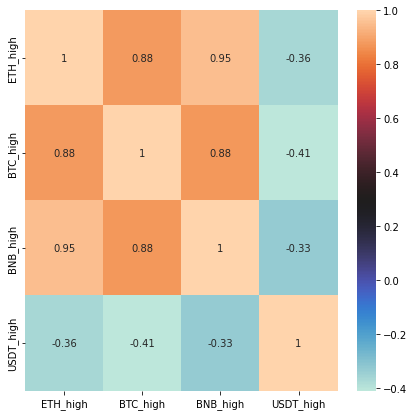

In [ ]:
plt.figure(figsize=(7, 7))
heatmap(df.corr(), cmap="icefire", annot=True)

In [ ]:
# Monte-carlo sample of the corr matrix

num_iter = 49

synth_data = generate_series(gen_tr,
                dataset[0][0][None].to(device).float(),
                minima, maxima,
                num_steps=150,
                num_series=4)[0]
matrix = torch.corrcoef(synth_data)
print(synth_data.mean())
for x in range(num_iter):
    synth_data = generate_series(gen_tr,
                dataset[0][0][None].to(device).float(),
                minima, maxima,
                num_steps=150,
                num_series=4)[0]
    matrix += torch.corrcoef(synth_data)

matrix /= (num_iter + 1)

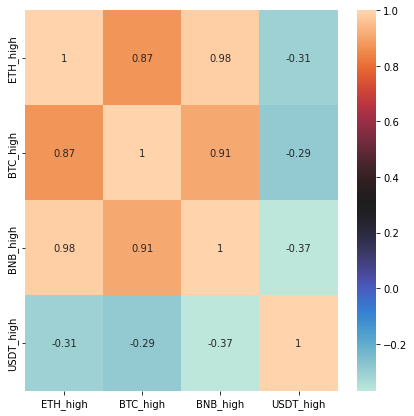

In [ ]:
plt.figure(figsize=(7, 7))
heatmap(matrix.cpu().detach(), cmap="icefire", annot=True,
        xticklabels=["ETH_high", "BTC_high", "BNB_high", "USDT_high"],
        yticklabels=["ETH_high", "BTC_high", "BNB_high", "USDT_high"])

  0%|          | 0/500 [00:00<?, ?it/s]

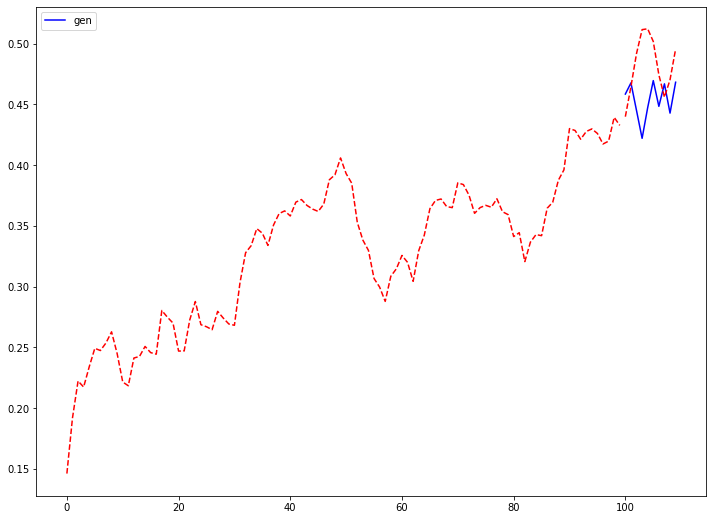

D_loss: 1.3990050554275513, G_loss: 7.335789680480957


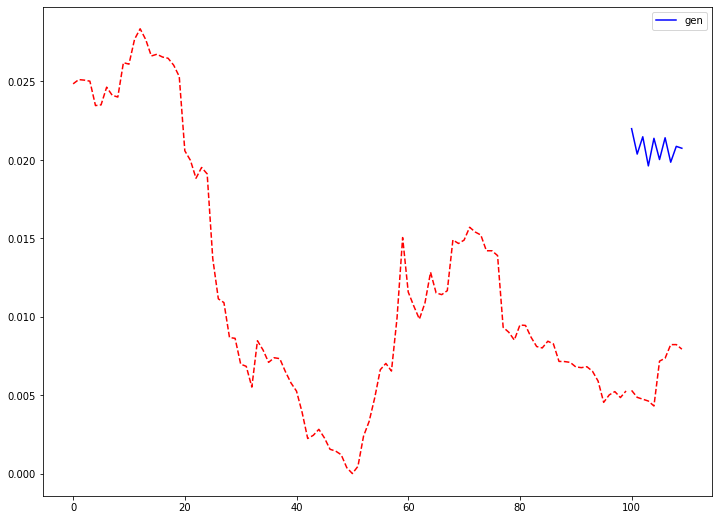

D_loss: 1.3229721784591675, G_loss: 2.715813636779785


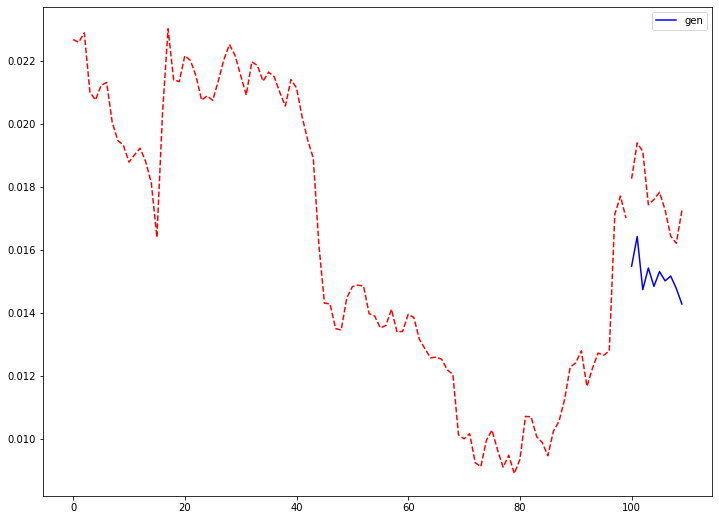

D_loss: 1.2900701761245728, G_loss: 2.251448154449463


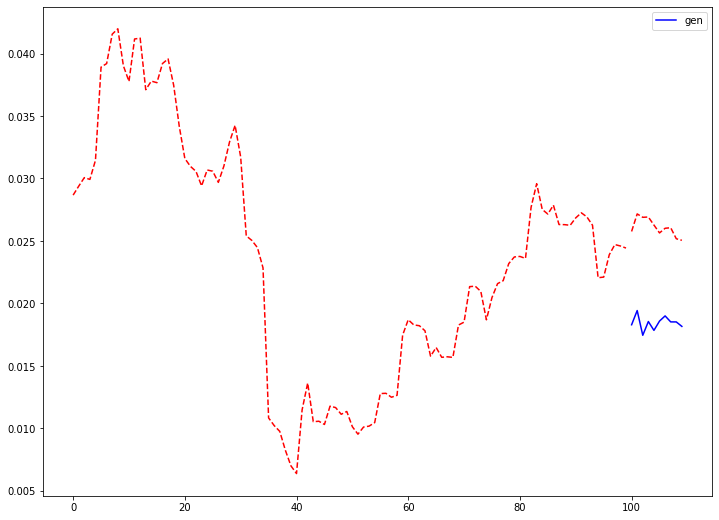

D_loss: 1.2664464712142944, G_loss: 2.0965960025787354


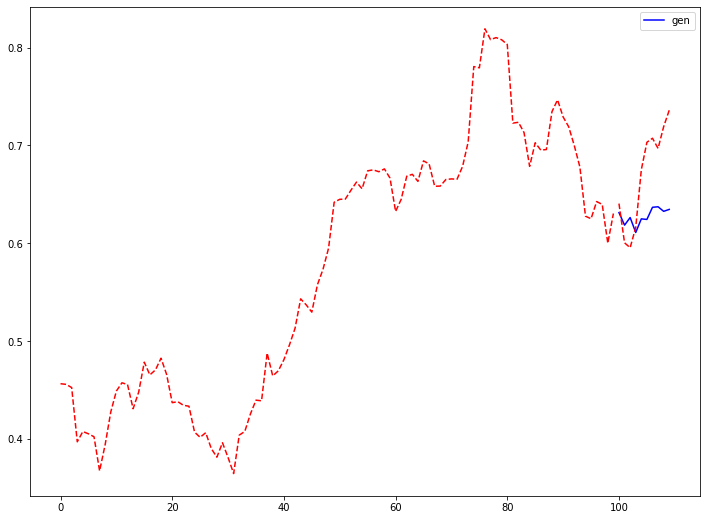

D_loss: 1.2509348392486572, G_loss: 2.020961046218872


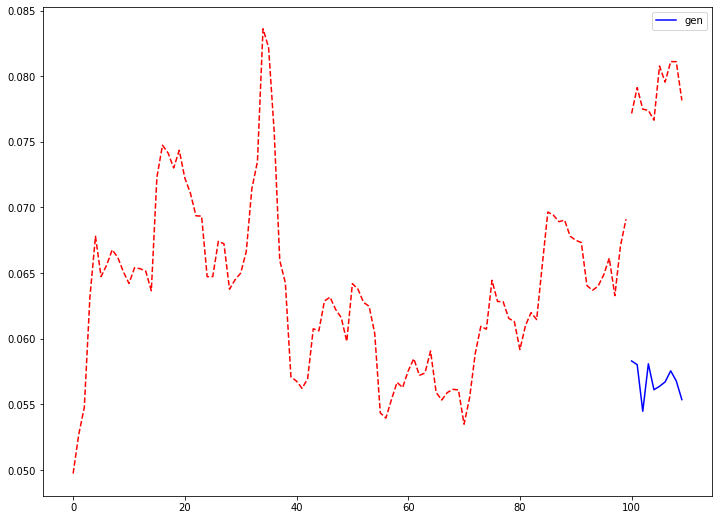

D_loss: 1.2389718294143677, G_loss: 1.9781547784805298


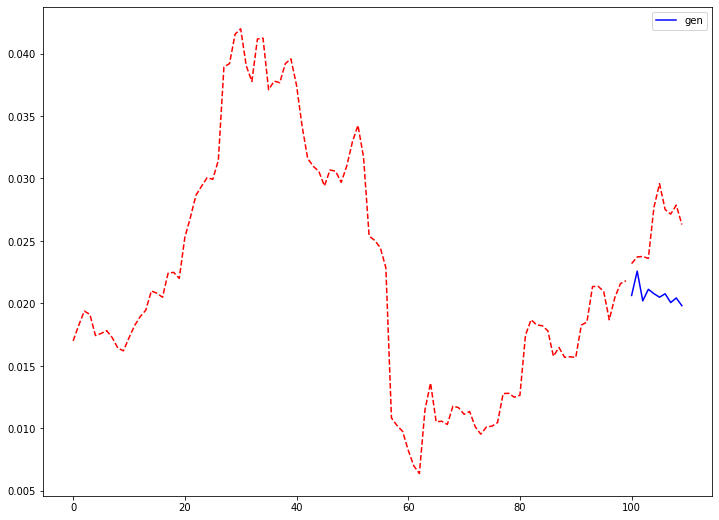

D_loss: 1.2307007312774658, G_loss: 1.9509727954864502


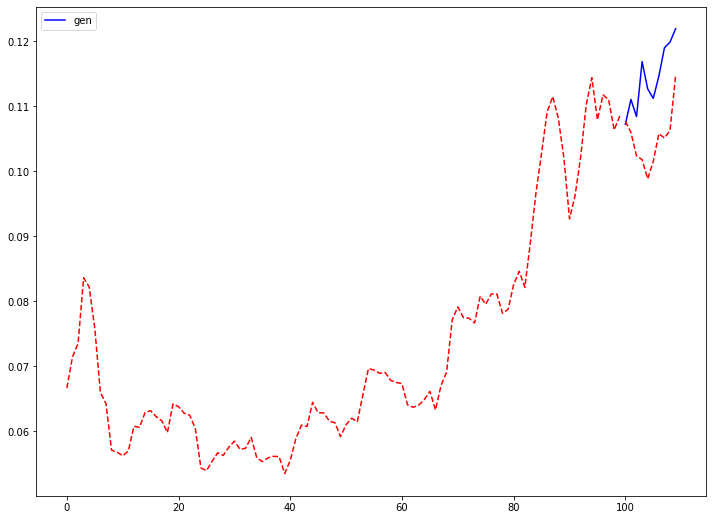

D_loss: 1.2244949340820312, G_loss: 1.930546522140503


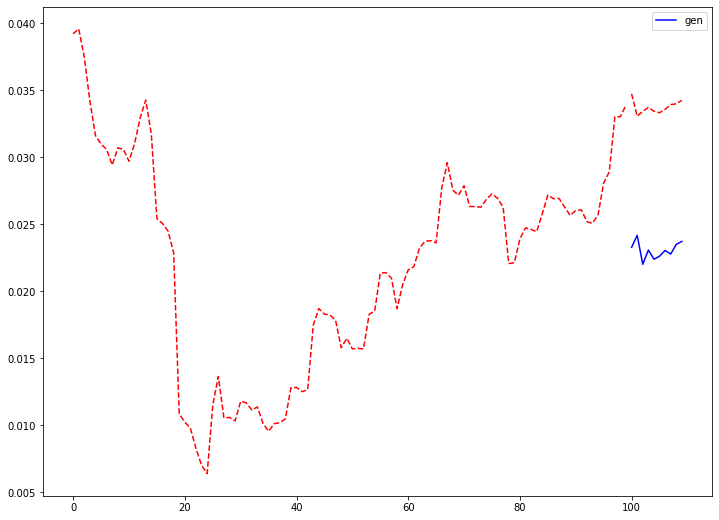

D_loss: 1.2197458744049072, G_loss: 1.9151506423950195


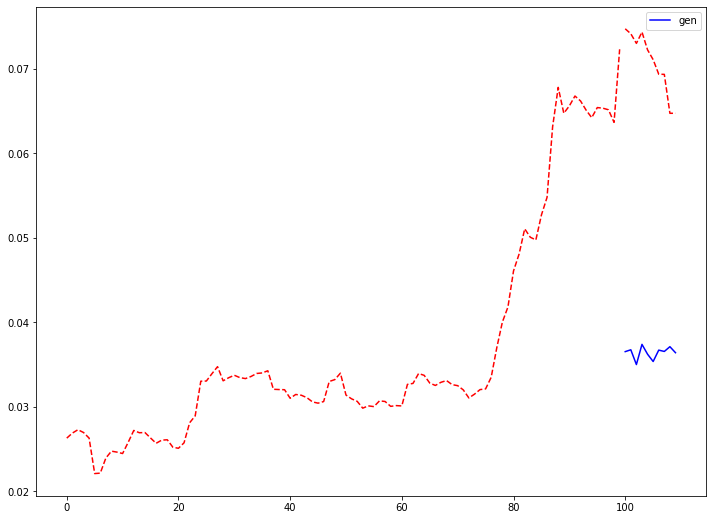

D_loss: 1.2161571979522705, G_loss: 1.9037984609603882


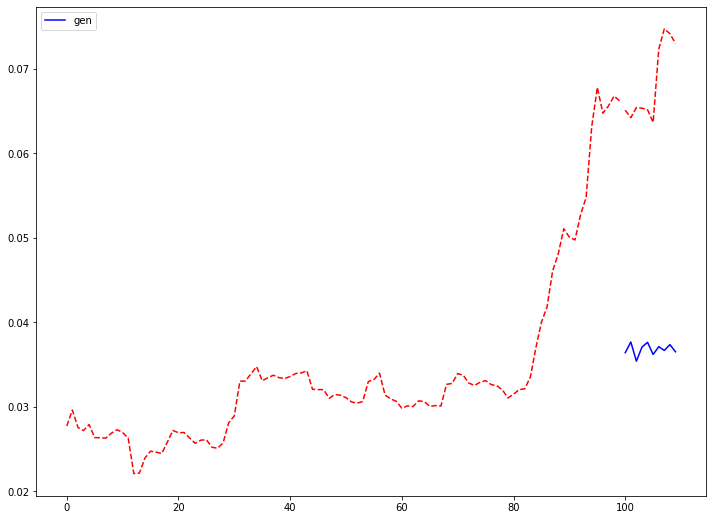

D_loss: 1.2132103443145752, G_loss: 1.8944205045700073


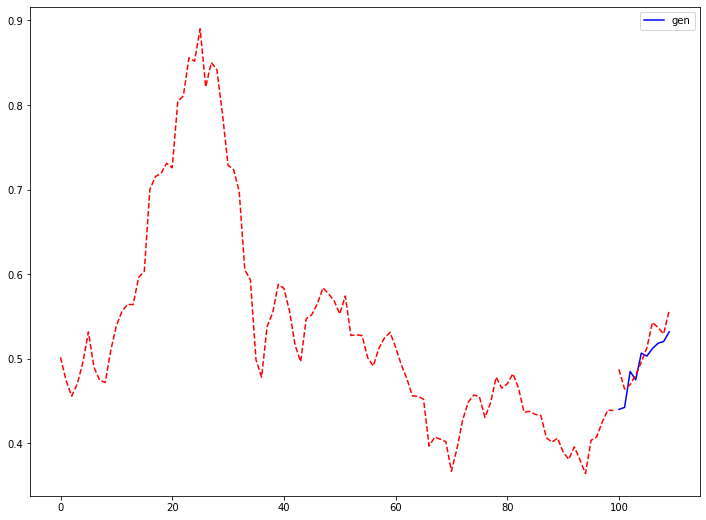

D_loss: 1.2109267711639404, G_loss: 1.8866609334945679


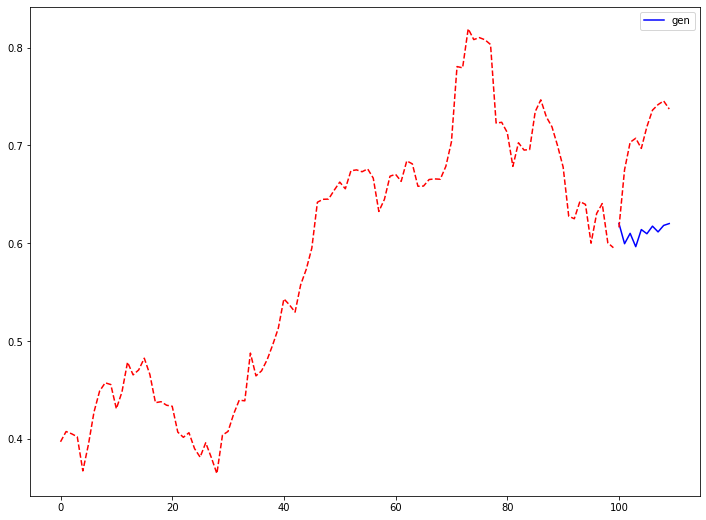

D_loss: 1.2090179920196533, G_loss: 1.8804713487625122


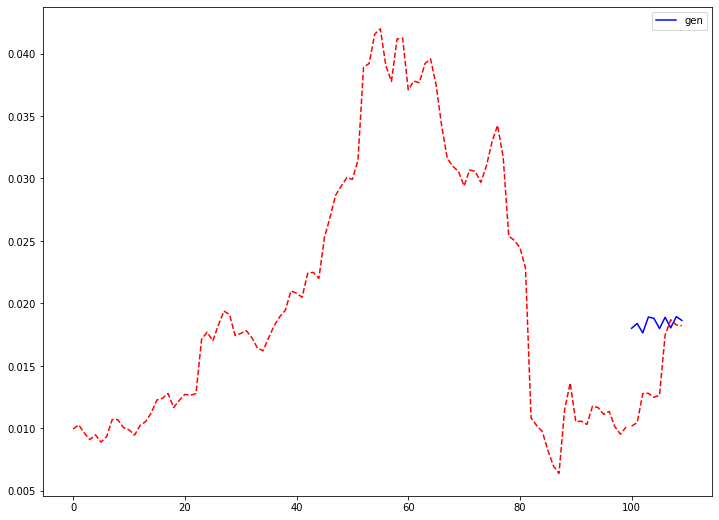

D_loss: 1.2073464393615723, G_loss: 1.8746777772903442


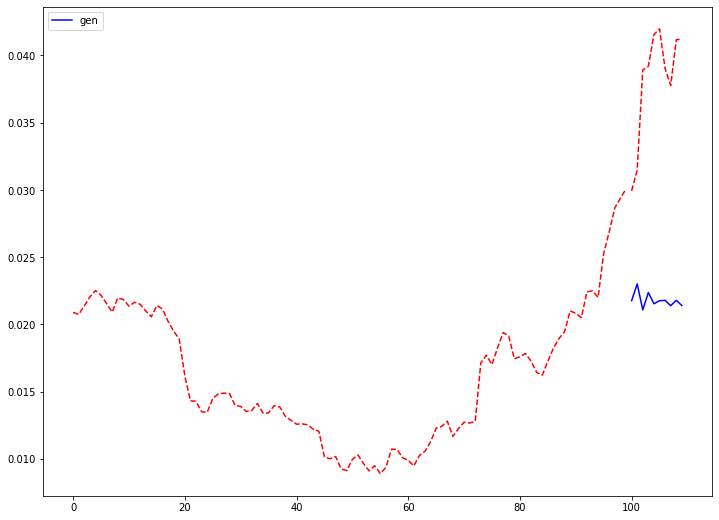

D_loss: 1.2058813571929932, G_loss: 1.870103359222412


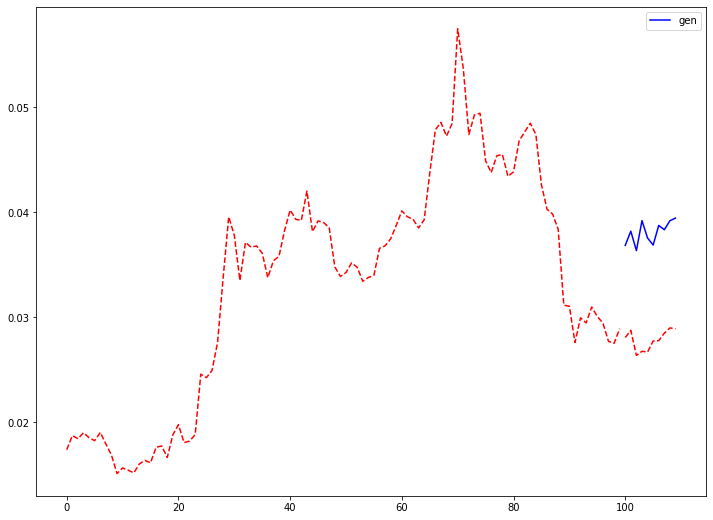

D_loss: 1.2046656608581543, G_loss: 1.8660833835601807


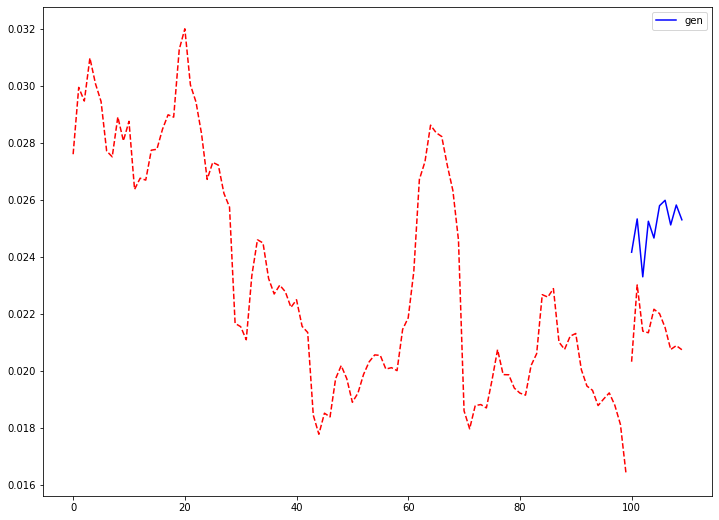

D_loss: 1.2036242485046387, G_loss: 1.8630824089050293


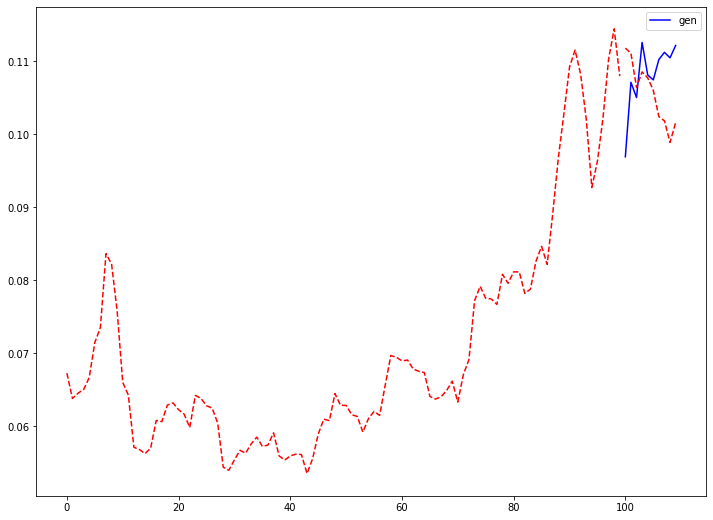

D_loss: 1.2026796340942383, G_loss: 1.8605241775512695


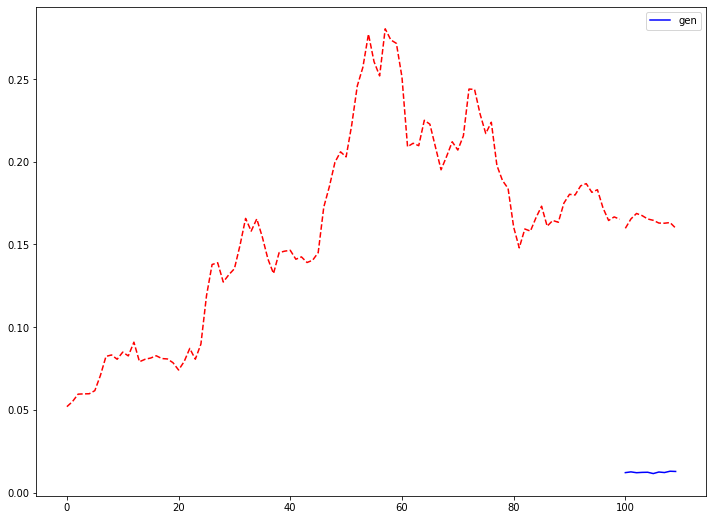

D_loss: 1.2018109560012817, G_loss: 1.857934832572937


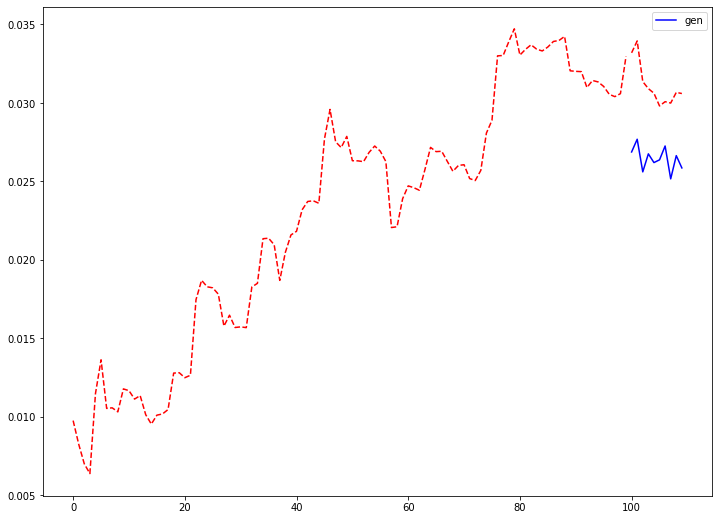

D_loss: 1.2010321617126465, G_loss: 1.8553386926651


In [ ]:
# just to an example of the learning process, not all the samples are quite good here still
gen_tr_2, disc_tr_2 = train_transformer(dataloader, num_series=4, num_epochs=500, 
                                              meta_flag=False, weights=[0, 0, 0, 0])

In [ ]:
synth_data = generate_series(gen_tr,
                dataset[0][0][None].to(device).float(),
                minima, maxima,
                num_steps=150,
                num_series=4)[0]

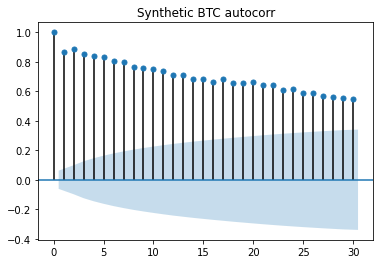

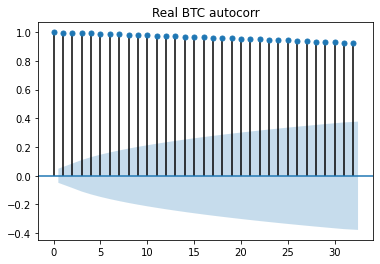

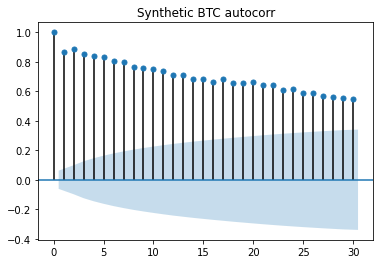

In [ ]:
# an example of autorcorr function estimated by the gan
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(scaled_data[1], title="Real BTC autocorr")
plot_acf(synth_data[1].cpu().detach(), title="Synthetic BTC autocorr")

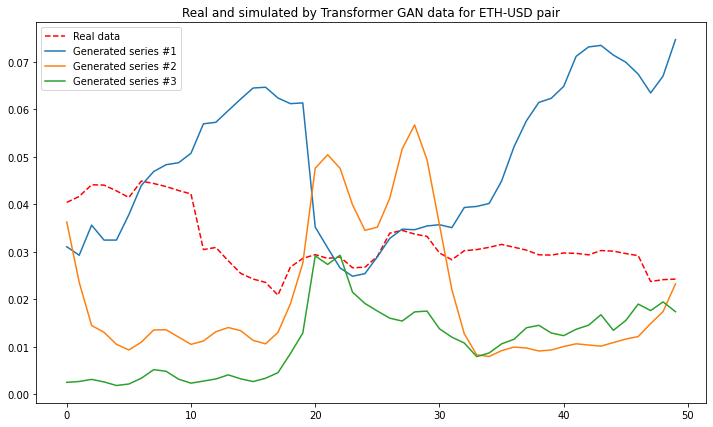

In [ ]:
### now lets draw some random 50 step examples

plot_generated_series(df["ETH_high"][190:340],
                      dataset[190][0][None].to(device).float(),
                      minima, maxima,
                      gen=gen_tr,
                      num_steps=5,
                      num_series=4,
                      pair_name="ETH-USD",
                      model_name="Transformer GAN",
                      num_trajectories=3,
                      series_to_plot = 0)

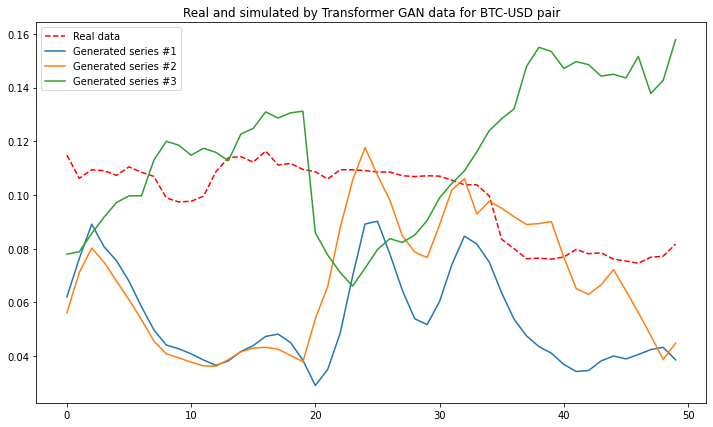

In [ ]:
plot_generated_series(df["BTC_high"][190:340],
                      dataset[190][0][None].to(device).float(),
                      minima, maxima,
                      gen=gen_tr,
                      num_steps=5,
                      num_series=4,
                      pair_name="BTC-USD",
                      model_name="Transformer GAN",
                      num_trajectories=3,
                      series_to_plot = 1)

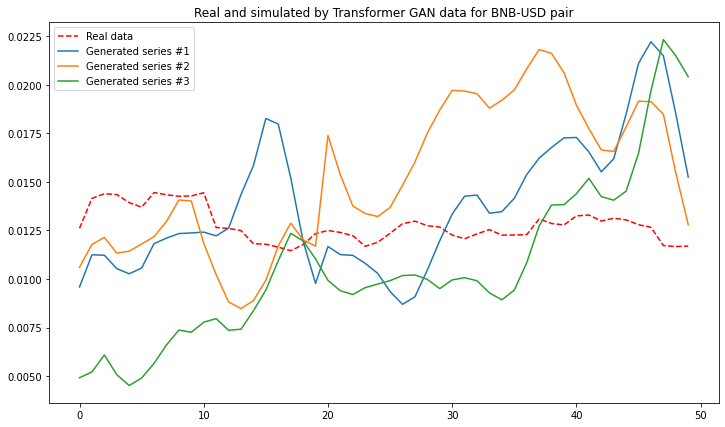

In [ ]:
# a bit more volatile then the real one
plot_generated_series(df["BNB_high"][190:340],
                      dataset[190][0][None].to(device).float(),
                      minima, maxima,
                      gen=gen_tr,
                      num_steps=5,
                      num_series=4,
                      pair_name="BNB-USD",
                      model_name="Transformer GAN",
                      num_trajectories=3,
                      series_to_plot = 2)

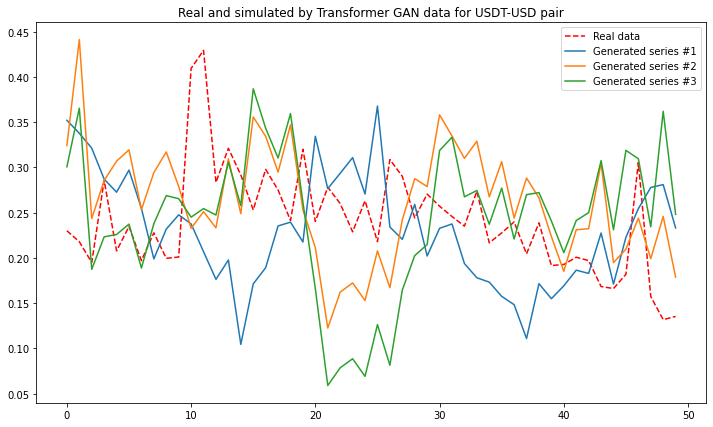

In [ ]:
plot_generated_series(df["USDT_high"][190:340],
                      dataset[190][0][None].to(device).float(),
                      minima, maxima,
                      gen=gen_tr,
                      num_steps=5,
                      num_series=4,
                      pair_name="USDT-USD",
                      model_name="Transformer GAN",
                      num_trajectories=3,
                      series_to_plot = 3)